In [1]:
from google.colab import drive
drive.mount('/content/drive')

import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import time

import skimage
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.feature import  peak_local_max

from keras.models import Model, load_model


#import tensorflow as tf

def dice_coefficient(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)
  return numerator / (denominator + tf.keras.backend.epsilon())



Mounted at /content/drive


# Utils

In [37]:
def preprocess_tree(img, new_w = 832 , new_h = 832 ,c= 3):
  img =cv2.resize(img, (new_w , new_h ), interpolation = cv2.INTER_AREA)
  img= np.reshape(img,  (1, new_w , new_h , c) )
  return img


def postprocess_tree(mask , w = 1440 ,h = 1920 , c = 3,  THR=0.07, MARGIN=200):
  new_w , new_h = 832 , 832
  mask=np.reshape(mask, (new_w , new_h) )
  mask =cv2.resize(mask, (w, h), interpolation = cv2.INTER_AREA)
  mask_centroid=[h//2, w//2]
  # filter
  filtered_mask =skimage.filters.gaussian(mask , sigma=10)
  # label image regions
  label_mask = skimage.measure.label(filtered_mask > THR, background=0, connectivity=2) #skimage.measure.label(label_image, background=None, return_num=False, connectivity=None)
  regions = skimage.measure.regionprops(label_mask )
  min=np.inf
  for region in regions:
    centroid=region.centroid
    distance=np.sqrt((centroid[0] - mask_centroid[0])**2+(centroid[1] - mask_centroid[1])**2)
    if region.area>20000 and distance<min:
      min=distance
      minr, minc, maxr, maxc=region.bbox
  # add margin and set limits
  minr=0 # np.min( [np.max([minr-MARGIN, 0]), 200] )
  minc= np.max([minc-MARGIN, 300])
  maxr= np.max( [np.min([maxr, h]), h-400])
  maxc= np.min([maxc+MARGIN, w-300])
  bbox = [minr, minc, maxr, maxc]
  return bbox


def cut_image(img, k, o):
  images=[]
  [height, width, channels] = np.shape(img)
  margin_img=np.zeros((height+2*o, width+2*o, channels))
  margin_img[o:-o, o:-o,:]=img
  dh, dw=int(height/k), int(width/k)
  for h in range(k):
    for w in range(k):
      h1,h2=int(dh*h), int(dh*(h+1)+2*o)
      w1,w2=int(dw*w), int(dw*(w+1)+2*o)
      #add overlap
      h1,h2=np.max([h1,0]), np.min([h2, height+2*o])
      w1,w2=np.max([w1,0]) , np.min([w2, width+2*o])
      im=margin_img[h1: h2, w1:w2,:]
      images.append(im)
  return images

def assemble_mask(masks,k, o):
  [_, height_o, width_o, _] = np.shape(masks[0])
  height, width= height_o-2*o, width_o-2*o
  mask=np.zeros((k*height, k*width))
  dh, dw=height, width
  for h in range(k):
    for w in range(k):
      h1,h2=int(dh*h), int(dh*(h+1))
      w1,w2=int(dw*w), int(dw*(w+1))
      m=masks[0]
      mask[h1: h2, w1:w2]= m[0, o:-o, o:-o, 0]
      masks.pop(0)
  return mask

def preprocess_cones(img, w= 1440 ,h = 1920 ,c = 3, OVERLAP=16, CUT=3):
  new_w = int(w/CUT+2*OVERLAP) # once cut and overlapped
  new_h = int(h/CUT+2*OVERLAP) 
  img =cv2.resize(img, (w, h), interpolation = cv2.INTER_AREA)
  # compute mask
  images = cut_image(img, k=CUT, o=OVERLAP)
  for i in range(len(images)):
    images[i]= np.reshape(images[i],  (1, new_h, new_w, c) )
  return images

def postprocess_cones(masks,  bbox ,  w = 1440 ,h = 1920 , OVERLAP=16, CUT=3):
  mask = assemble_mask(masks,  k=CUT, o=OVERLAP)
  [minr, minc, maxr, maxc]=bbox
  new_mask= np.zeros_like(mask)
  new_mask[minr:maxr, minc:maxc]=mask[minr:maxr, minc:maxc]
  # coordinate with local min
  coordinates =  peak_local_max(new_mask, min_distance=3, threshold_abs=0.3)
  nb = len(coordinates)
  # coordinate with connected regions
  #label_mask = skimage.measure.label(new_mask >0.3, background=0, connectivity=1) 
  #regions = skimage.measure.regionprops(label_mask )
  #nb = len(regions)
  #coordinates=np.array([ [int(regions[i].centroid[0]),int(regions[i].centroid[1])]  for i in range(nb)])
  return nb, coordinates

def predict(id):
  img_name='tree'+str(id)+'.jpg'
  img_path=os.path.join(images_dir, img_name)
  img = imread(img_path)[:,:,:]
  #find central tree
  im= preprocess_tree(img)
  mask = model_tree.predict(im)
  bbox=postprocess_tree(mask)
  # find nb cones
  masks = []
  images = preprocess_cones(img)
  for im in images:
    mask = model_cone.predict(im)
    masks.append(mask)
  nb, coordinates = postprocess_cones(masks,  bbox)
  return nb, coordinates, img

# Import data

In [51]:
code_dir='/content/drive/Shared drives/fir_cone_detector'
images_dir=code_dir+'/data/images'
images_list = os.listdir(images_dir)
masks_dir=code_dir+'/data/masks'
masks_list=os.listdir(masks_dir)
print(mask_list)

['tree21_cone.ome.tiff', 'tree1_cone.ome.tiff', 'tree4_cone.ome.tiff', 'tree3_cone.ome.tiff', 'tree2_cone.ome.tiff', 'tree5_cone.ome.tiff', 'tree10_cone.ome.tiff', 'tree13_cone.ome.tiff', 'tree15_cone.ome.tiff', 'tree14_cone.ome.tiff', 'tree23_cone.ome.tiff', 'tree22_cone.ome.tiff', 'tree17_cone.ome.tiff', 'tree18_cone.ome.tiff', 'tree25_cone.ome.tiff', 'tree26_cone.ome.tiff', 'tree31_cone.ome.tiff', 'tree40_cone.ome.tiff', 'tree39_cone.ome.tiff', 'tree41_cone.ome.tiff', 'tree42_cone.ome.tiff', 'tree51_cone.ome.tiff', 'tree48_cone.ome.tiff', 'tree45_cone.ome.tiff', 'tree35_cone.ome.tiff', 'tree6_cone.ome.tiff', 'tree8_cone.ome.tiff', 'tree9_cone.ome.tiff', 'tree7_cone.ome.tiff', 'tree12_cone.ome.tiff', 'tree11_cone.ome.tiff', 'tree19_cone.ome.tiff', 'tree16_cone.ome.tiff', 'tree32_cone.ome.tiff', 'tree33_cone.ome.tiff', 'tree29_cone.ome.tiff']


# Model

### Import Model from directory

In [5]:
weight_path='/content/drive/Shareddrives/fir_cone_detector/models/training/unet_k3.h5'
model_cone=keras.models.load_model(weight_path, custom_objects={'dice_coefficient': dice_coefficient})
weight_path='/content/drive/Shareddrives/fir_cone_detector/models/training/unet_tree.h5'
model_tree=keras.models.load_model(weight_path, custom_objects={'dice_coefficient': dice_coefficient})

# Produce result

In [6]:
path= "/content/drive/Shareddrives/fir_cone_detector/data/prediction.csv"
prediction= pd.read_csv(path , delimiter=';')
count_img=prediction['count_img']
count_exhaustive=prediction['count_exhaustive']
prediction.head

<bound method NDFrame.head of     tree_id  count_img  count_exhaustive
0         1        328               402
1         2        234               352
2         3         52                50
3         4       1443              3108
4         5        420               823
5         6       1751              3209
6         7       1600              3588
7         8         88               132
8         9         26                27
9        10        293               853
10       11       1225              2643
11       12        399               468
12       13        203               324
13       14        243               323
14       15         69               147
15       16        829              2536
16       17        853              2484
17       18        322               664
18       19        644               646
19       20        109               191
20       21        617              1391
21       22        368               731
22       23         99     

In [38]:
my_prediction=[]
for id in range(1, len(images_list)+1):
  nb, coordinates, img=predict(id)
  my_prediction.append([nb])
  nb_img=count_img[int(id-1)]
  nb_exhaustive=count_exhaustive[int(id-1)]
  print('tree',id,': ', nb, ' cones; imageJ=', nb_img, '; exhaustive=', nb_exhaustive)

# save data to csv file
#df= pd.DataFrame(data=my_prediction, index=None, columns=['tree_id', 'nb_of_cones'])
#df.to_csv('prediction.csv', index=False)

tree 1 :  390  cones; imageJ= 328 ; exhaustive= 402
tree 2 :  285  cones; imageJ= 234 ; exhaustive= 352
tree 3 :  329  cones; imageJ= 52 ; exhaustive= 50
tree 4 :  806  cones; imageJ= 1443 ; exhaustive= 3108
tree 5 :  398  cones; imageJ= 420 ; exhaustive= 823
tree 6 :  937  cones; imageJ= 1751 ; exhaustive= 3209
tree 7 :  906  cones; imageJ= 1600 ; exhaustive= 3588
tree 8 :  500  cones; imageJ= 88 ; exhaustive= 132
tree 9 :  82  cones; imageJ= 26 ; exhaustive= 27
tree 10 :  375  cones; imageJ= 293 ; exhaustive= 853
tree 11 :  1110  cones; imageJ= 1225 ; exhaustive= 2643
tree 12 :  541  cones; imageJ= 399 ; exhaustive= 468
tree 13 :  340  cones; imageJ= 203 ; exhaustive= 324
tree 14 :  412  cones; imageJ= 243 ; exhaustive= 323
tree 15 :  168  cones; imageJ= 69 ; exhaustive= 147
tree 16 :  862  cones; imageJ= 829 ; exhaustive= 2536
tree 17 :  1142  cones; imageJ= 853 ; exhaustive= 2484
tree 18 :  438  cones; imageJ= 322 ; exhaustive= 664
tree 19 :  612  cones; imageJ= 644 ; exhaustive= 6

tree 48 :  288  cones  IMAGEJ= 454  exhaustive= 1699
loss1= 0.36563876651982374  loss2= 0.8304885226603884


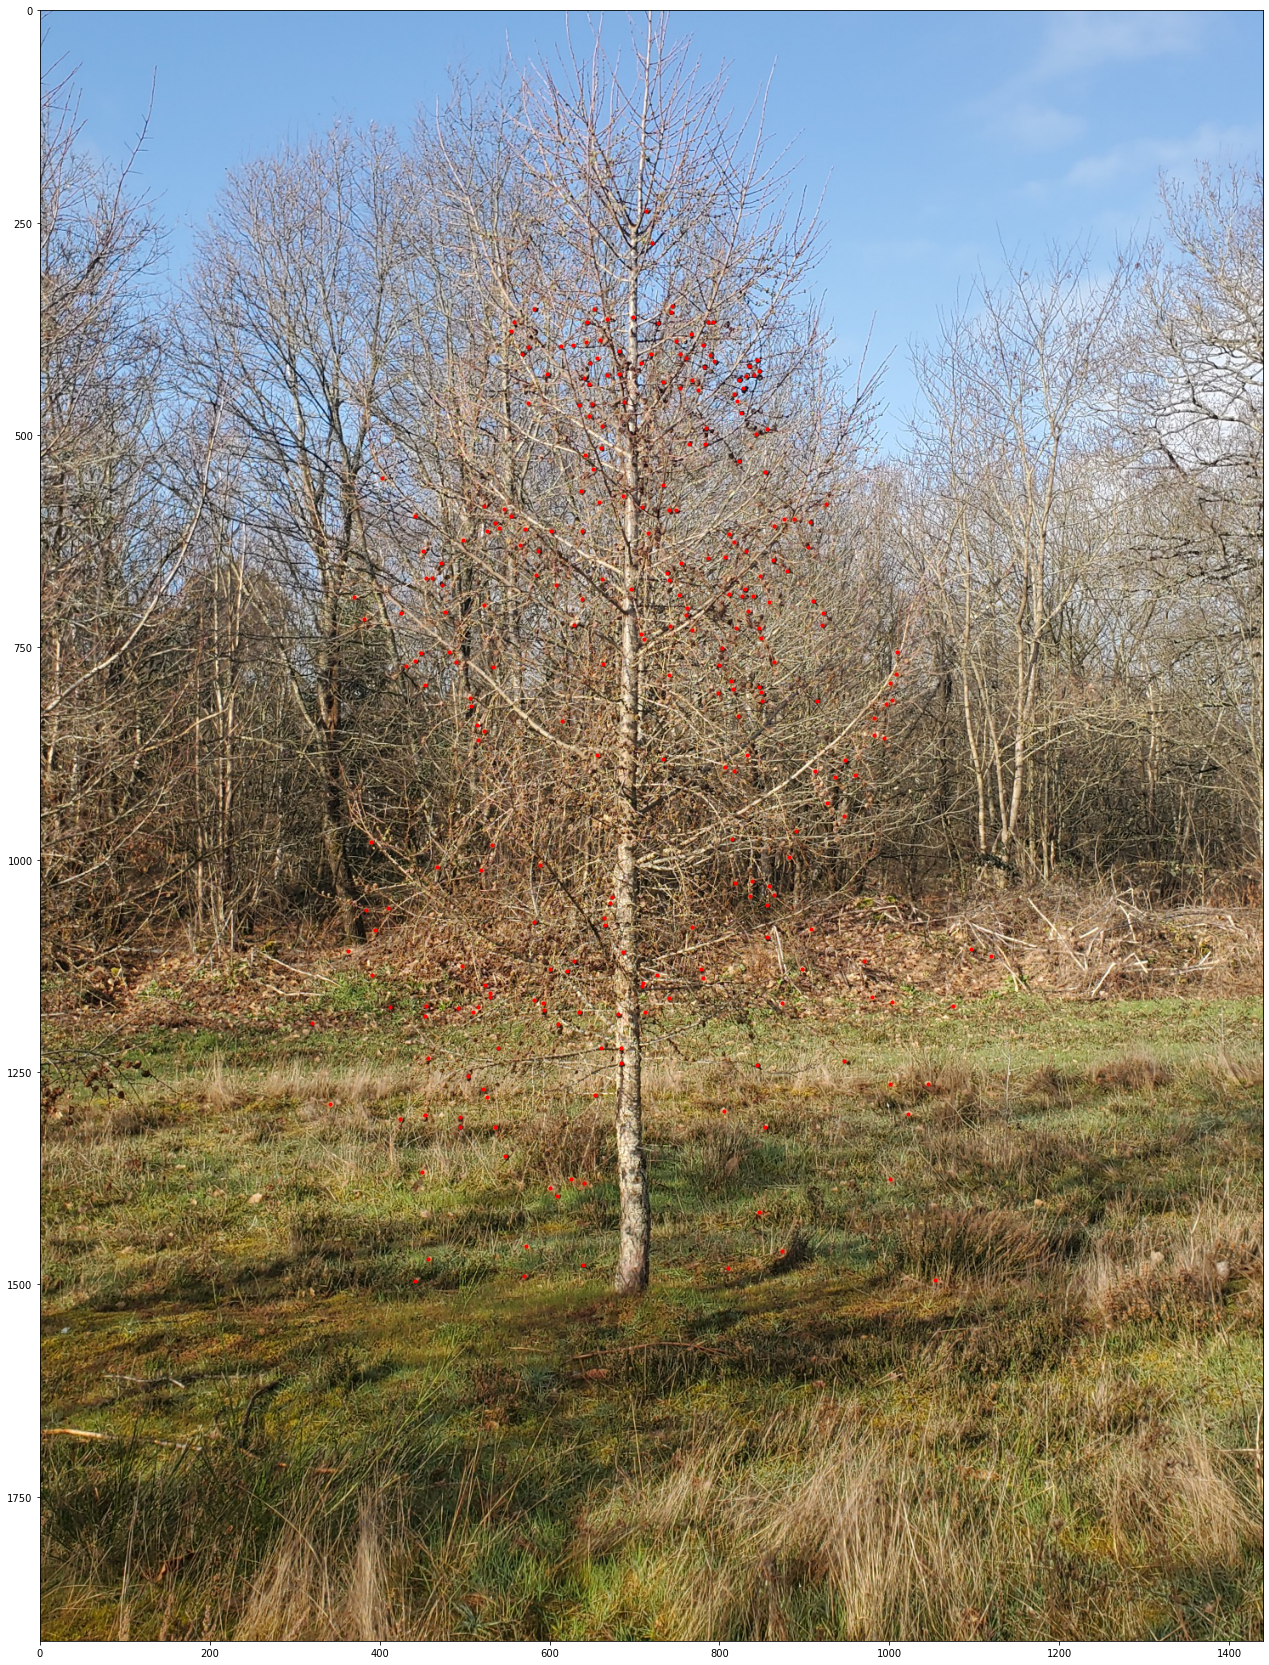

In [45]:
#  4, 6, 7, 21, 27, 29, 44, 48, 49
id=np.random.randint(len(images_list))
id=48
nb, coordinates, img=predict(id)
print('tree',id,': ', nb, ' cones', ' IMAGEJ=',count_img[int(id-1)], ' exhaustive=', count_exhaustive[int(id-1)])
loss1=1-(nb/count_img[int(id-1)])
loss2=1-(nb/count_exhaustive[int(id-1)])
print('loss1=', loss1, ' loss2=', loss2)
fig3, (ax1)=plt.subplots(1,1,figsize=(30,30))
ax1.imshow(img)
ax1.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

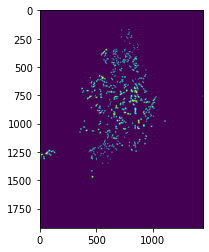

In [53]:
mask_path=masks_dir+'/tree48_cone.ome.tiff'
mask= imread(mask_path)[:,:]
plt.imshow(mask)

# Find exhaustive=f(count)

In [115]:
def f(X, a,b):
  out=[]
  for x in X:
    out.append(int(a*x+b))
  return out


Text(0.5, 1.0, 's=0.73 a=3.3 b=-555.98s poly=0.76')

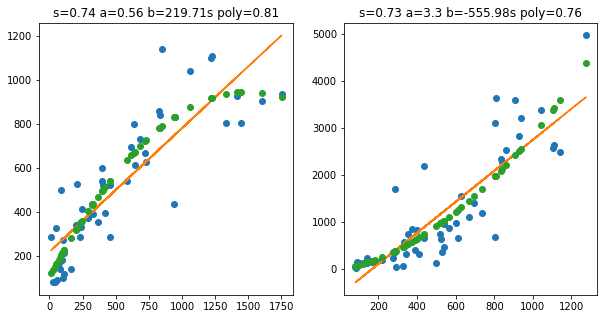

In [117]:
Z=np.array(prediction['count_exhaustive']) # target
Y=np.array(prediction['count_img'])
X=np.array(my_prediction)
Z_cut=np.concatenate((X[0:33], X[34:43], X[44:]), axis=None)
Y_cut=np.concatenate((Y[0:33], Y[34:43], Y[44:]), axis=None)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
#linear regression
Z_cut=np.reshape(Z_cut, (len(Z_cut),1) )
Y_cut=np.reshape(Y_cut, (len(Y_cut), 1) )
reg = LinearRegression().fit( Y_cut, Z_cut)
score_y=reg.score(Y_cut, Z_cut)
ay, by= float(reg.coef_) , float(reg.intercept_)
#poly regression
Y_cut=np.reshape(Y_cut, (len(Y_cut),) )
Z_cut=np.reshape(Z_cut, (len(Z_cut),) )
mymodely = np.poly1d(np.polyfit(Y_cut, Z_cut, 2))
ry=r2_score(Z_cut, mymodely(Y_cut))
title_y= 's='+str(round(score_y,2))+' a='+str(round(ay,2))+' b='+str(round(by,2))+'s poly='+str(round(ry,2))


#linear regression
X=np.reshape(X, (len(X),1) )
Z=np.reshape(Z, (len(Z), 1) )
reg = LinearRegression().fit(X, Z)
ax, bx= float(reg.coef_) , float(reg.intercept_)
score_x=reg.score(X, Z)
#poly regression
X=np.reshape(X, (len(X),) )
Z=np.reshape(Z, (len(Z),) )
mymodelx = np.poly1d(np.polyfit(X, Z, 2))
rx=r2_score(Z, mymodelx(X))
title_x= 's='+str(round(score_x,2))+' a='+str(round(ax,2))+' b='+str(round(bx,2))+'s poly='+str(round(rx,2))

fig, (ax1, ax2)=plt.subplots(1,2, figsize=(10, 5))
ax1.plot(Y_cut, Z_cut, 'o')
ax1.plot(Y_cut, f(Y_cut,a=ay, b=by))
ax1.plot(Y_cut, mymodely(Y_cut), 'o')
ax1.set_title(title_y)
ax2.plot(X,Z, 'o')
ax2.plot(X, f(X,a=ax, b=bx))
ax2.plot(X, mymodelx(X), 'o')
ax2.set_title(title_x)

In [118]:
#find worst pred
ranking=[]
for i in range(len(X)):
  id=i+1
  reg=f([X[i]], a=az, b=bz)
  reg=reg[0]
  pred=my_prediction[i]
  pred=pred[0]
  ranking.append((id, abs(reg-pred)))
dtype= [('id', int), ('error', float)]
ranking=np.array(ranking, dtype=dtype)
sorted=np.sort(ranking, order='error') 
print(sorted) 

[(20,   59.) (23,   72.) ( 2,   99.) (48,  106.) (32,  109.) (38,  138.)
 (15,  169.) ( 3,  201.) (41,  203.) (13,  226.) (40,  226.) (36,  233.)
 (22,  260.) (37,  282.) (10,  306.) (50,  330.) ( 1,  341.) (47,  348.)
 ( 5,  359.) ( 9,  367.) (51,  371.) (14,  392.) (29,  447.) (18,  451.)
 ( 8,  594.) (30,  642.) (27,  647.) (25,  659.) (12,  688.) (42,  688.)
 (34,  741.) (43,  829.) (19,  852.) (35,  891.) (31,  981.) (21, 1043.)
 (45, 1133.) (33, 1291.) ( 4, 1298.) (49, 1301.) (39, 1360.) (46, 1379.)
 (16, 1427.) ( 7, 1528.) (26, 1574.) ( 6, 1600.) (24, 1837.) (28, 1982.)
 (11, 1998.) (17, 2071.) (44, 2378.)]


# mauvaise idee


In [73]:
from keras import  Sequential
from keras.layers import Dense, Lambda, Dropout

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Z/5000,X/5000, test_size=0.33, shuffle=True)

In [76]:
def build_model():
  model=Sequential()
  #model.add(Lambda(lambda x: x / 5000) )
  model.add(Dense(10, input_shape=(1,)))
  model.add(Dense(10))
  model.add(Dense(1))
  #model.add(Lambda(lambda x: x * 5000) )
  model.compile(loss='mse', optimizer='adam')
  return model
model=build_model()

In [77]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('UNet.h5', verbose=1, save_best_only=True)
history = model.fit(X_train,y_train, epochs=50,  validation_data=(X_test, y_test), callbacks=[earlystopper, checkpointer])

Epoch 1/50
2/2 [==============================] - 0s 91ms/step - loss: 0.1314 - val_loss: 0.1057

Epoch 00001: val_loss improved from inf to 0.10567, saving model to UNet.h5
Epoch 2/50
2/2 [==============================] - 0s 15ms/step - loss: 0.1204 - val_loss: 0.0961

Epoch 00002: val_loss improved from 0.10567 to 0.09608, saving model to UNet.h5
Epoch 3/50
2/2 [==============================] - 0s 19ms/step - loss: 0.1105 - val_loss: 0.0876

Epoch 00003: val_loss improved from 0.09608 to 0.08757, saving model to UNet.h5
Epoch 4/50
2/2 [==============================] - 0s 14ms/step - loss: 0.1015 - val_loss: 0.0796

Epoch 00004: val_loss improved from 0.08757 to 0.07960, saving model to UNet.h5
Epoch 5/50
2/2 [==============================] - 0s 17ms/step - loss: 0.0942 - val_loss: 0.0728

Epoch 00005: val_loss improved from 0.07960 to 0.07285, saving model to UNet.h5
Epoch 6/50
2/2 [==============================] - 0s 16ms/step - loss: 0.0874 - val_loss: 0.0674

Epoch 00006: val

[390]
[285]
[329]
[806]
[398]
[937]
[906]
[500]
[82]
[375]
[1110]
[541]
[340]
[412]
[168]
[862]
[1142]
[438]
[612]
[216]
[695]
[355]
[273]
[1040]
[528]
[926]
[523]
[1103]
[436]
[521]
[668]
[289]
[803]
[564]
[629]
[140]
[119]
[182]
[833]
[143]
[330]
[541]
[602]
[1275]
[734]
[841]
[90]
[288]
[807]
[98]
[80]
[262, 191, 221, 542, 268, 630, 609, 336, 55, 252, 747, 364, 228, 277, 113, 580, 768, 294, 412, 145, 467, 239, 183, 700, 355, 623, 352, 742, 293, 350, 449, 194, 540, 379, 423, 94, 80, 122, 560, 96, 222, 364, 405, 858, 494, 566, 60, 193, 543, 66, 53]


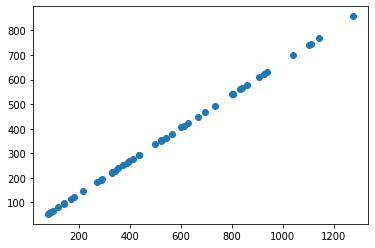

In [83]:
pred=[]
for i in Z:
  print(i)
  iz=np.array([int(i)])
  p=model.predict(iz)
  pred.append(int(p))
plt.plot(Z, pred , 'o')
print(pred)